# **Starting Set-up**

In [ ]:
# Install Required Libs
#======================
!pip install transformers
!pip install PyDrive
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Required Packages
#=========================

# General Purpose Packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import train_test_split

# # Naive Bayes
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB

# Transformers Model & Tokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification

# Transformers Function for Create Input Example & Input Feature
from transformers import InputExample, InputFeatures

# Keras
import tensorflow as tf
from tensorflow import keras

# Model Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools

## Connect to G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Define Model & Tokenizer**

In [ ]:
# Define Model
#=============
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",  
                                                        from_pt = True,
                                                        num_labels = 3)       # Set jumlah kelas / label yang akan diprediksi model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define Tokenizer
#=================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Get Model Information
#======================
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


# **Data Pre-processing**

In [ ]:
# Define URLs for Data from G-Drive
#==================================
proj_path = '/content/gdrive/MyDrive/data/'

## Train Data

In [ ]:
# Set Data Into Datafram
#=======================
df_train = pd.read_csv(proj_path + 'twitter_processed_data_train.csv')
df_train = df_train.dropna()

# Get Data Info
#==============
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    6500 non-null   int64 
 1   DATA_COLUMN   6500 non-null   object
 2   LABEL_COLUMN  6500 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 152.5+ KB


In [ ]:
# Test Call
#==========
print("Data Distribution:\n", df_train['LABEL_COLUMN'].value_counts())
print("\n")
print("df_train shape: ", df_train.shape)
print('\n')
print(df_train.head())

Data Distribution:
 0    2677
2    1983
1    1840
Name: LABEL_COLUMN, dtype: int64


df_train shape:  (6500, 3)


   Unnamed: 0                                        DATA_COLUMN  LABEL_COLUMN
0           0  Right folks, really must go now; have to babys...             0
1           1                                    Happy birthday.             2
2           2                              your not following us             1
3           3                                   cant wait to see             2
4           4  Enjoyed see`n everyone last night! even tho it...             0


### Split Train DF Base On Label

In [ ]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, random_state=1, shuffle=True)
tkf = []
vkf = []
train_input = []
valid_input = []

train_array = df_train.DATA_COLUMN.to_numpy()
y_train_array = df_train.LABEL_COLUMN.to_numpy()

for t_idx, v_idx in cv.split(train_array, y_train_array):
    x_train, x_val = train_array[t_idx], train_array[v_idx]
    y_train, y_val = y_train_array[t_idx], y_train_array[v_idx]

### Resampling Process

In [ ]:
x_list = x_train.tolist()
y_list = y_train.tolist()
x_list_val = x_val.tolist()
y_list_val = y_val.tolist()

traindata_df = pd.DataFrame(x_list, columns=['DATA_COLUMN'])
trainlabel_df = pd.DataFrame(y_list, columns=['LABEL_COLUMN'])
valdata_df = pd.DataFrame(x_list_val, columns=['DATA_COLUMN'])
vallabel_df = pd.DataFrame(y_list_val, columns=['LABEL_COLUMN'])

### Merge Resampled Data Into Train_DF_Resampled

In [ ]:
train_df = pd.concat([traindata_df, trainlabel_df], axis=1)
val_df = pd.concat([valdata_df, vallabel_df], axis=1)

tkf.append(train_df)
vkf.append(val_df)
train_input.append(x_train)
valid_input.append(x_val)

## Valid Data

In [ ]:
# Set Data Into Datafram
#=======================
df_valid = pd.read_csv(proj_path + 'twitter_processed_data_valid.csv')
df_valid = df_valid.dropna()

# Get Data Info
#==============
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2275 non-null   int64 
 1   DATA_COLUMN   2275 non-null   object
 2   LABEL_COLUMN  2275 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.4+ KB


In [ ]:
# Test Call
#==========
print(df_valid.shape)
print('\n')
print(df_valid.head())

(2275, 3)


   Unnamed: 0                                   DATA_COLUMN  LABEL_COLUMN
0           0                                       laughs!             2
1           1  I already know what happens on Supernatural.             0
2           2                                    recession.             1
3           3                                      #yourock             2
4           4                                          fave             2


## Test Data

In [ ]:
# Set Data Into Datafram
#=======================
df_test = pd.read_csv(proj_path + 'twitter_processed_data_test.csv')
df_test = df_test.dropna()

# Get Data Info
#==============
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1225 non-null   int64 
 1   DATA_COLUMN   1225 non-null   object
 2   LABEL_COLUMN  1225 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.8+ KB


In [ ]:
# Test Call
#==========
print(df_test.shape)
print('\n')
print(df_test.head())

(1225, 3)


   Unnamed: 0                                        DATA_COLUMN  LABEL_COLUMN
0           0  pretty much ever HP except the one i wanted to...             2
1           1                                              broke             1
2           2  Did you get your free chocolate?!? I still hav...             0
3           3                                      thats funny..             1
4           4                                    Dont worry man.             2


# **Create Input Example & Features**

## Create Function 

In [ ]:
# Function For Convert Data Into Input Example
#=============================================
def convert_data_to_examples(df_train, df_valid, df_test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = df_train.apply(lambda x: InputExample(guid   = None,                       # Globally unique ID for bookkeeping, unused in this case
                                                           text_a = x[DATA_COLUMN], 
                                                           text_b = None,
                                                           label  = x[LABEL_COLUMN]),axis = 1)

  validation_InputExamples = df_valid.apply(lambda x: InputExample(guid   = None,                  # Globally unique ID for bookkeeping, unused in this case
                                                                text_a = x[DATA_COLUMN], 
                                                                text_b = None,
                                                                label  = x[LABEL_COLUMN]), axis = 1)
  
  test_InputExamples = df_test.apply(lambda x: InputExample(guid   = None,                         # Globally unique ID for bookkeeping, unused in this case
                                                         text_a = x[DATA_COLUMN], 
                                                         text_b = None,
                                                         label  = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples, test_InputExamples


# Function For Convert Input Example Into TF Dataset
#===================================================
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            padding='max_length',
            verbose=False
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                     input_dict["token_type_ids"],
                                                     input_dict["attention_mask"])


        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'


## Convert Data

In [ ]:
# Convert Into Input Example
#===========================
train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(df_train, df_valid, df_test, DATA_COLUMN, LABEL_COLUMN)

# Convert Into TF Dataset or Features
#====================================
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(16)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(16)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(16)


# **Main Experiment**

In [ ]:
# Compile Model for Training
#===========================
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5, epsilon = 1e-08, clipnorm = 1.0), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [ ]:
# Model Training
#===============
training_history = model.fit(train_data,
                             epochs = 10,
                             validation_data = validation_data)


Epoch 1/10
407/407 [==============================] - 271s 519ms/step - loss: 0.4409 - accuracy: 0.8368 - val_loss: 0.2714 - val_accuracy: 0.9108
Epoch 2/10
407/407 [==============================] - 192s 471ms/step - loss: 0.2122 - accuracy: 0.9300 - val_loss: 0.2107 - val_accuracy: 0.9389
Epoch 3/10
407/407 [==============================] - 189s 465ms/step - loss: 0.1064 - accuracy: 0.9657 - val_loss: 0.1927 - val_accuracy: 0.9503
Epoch 4/10
407/407 [==============================] - 190s 466ms/step - loss: 0.0520 - accuracy: 0.9868 - val_loss: 0.2410 - val_accuracy: 0.9508
Epoch 5/10
407/407 [==============================] - 209s 514ms/step - loss: 0.0404 - accuracy: 0.9880 - val_loss: 0.2588 - val_accuracy: 0.9459
Epoch 6/10
407/407 [==============================] - 209s 513ms/step - loss: 0.0357 - accuracy: 0.9897 - val_loss: 0.2744 - val_accuracy: 0.9486
Epoch 7/10
407/407 [==============================] - 189s 464ms/step - loss: 0.0301 - accuracy: 0.9915 - val_loss: 0.2665 -

# **Test Predict & Test Evaluation**

In [ ]:
# Define Test Sentence
#=====================
pred_sentences = ['I Like you',
                  'I don`t like you']

In [ ]:
# Tokenizer Test Sentence
#========================
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')

# Predict Label
#==============
tf_outputs = model(tf_batch)

# Softmax Final Score For Label Predict
#======================================
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

# Argmax The Score To Get Single Label
#=====================================
label = tf.argmax(tf_predictions, axis=1)

# Convert Into Numpy Array
#=========================
label = label.numpy()

# Get Final Label
#================
labels = ['Positive','Negative','Neutral']
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

I Like you : 
 Neutral
I don`t like you : 
 Negative


In [ ]:
# Simple Model Evaluation Base On Test Sentences
#===============================================
test_results = model.evaluate(test_data)
print('Test Loss:', test_results[0])
print('Test Accuracy:', test_results[1])

77/77 [==============================] - 12s 150ms/step - loss: 0.2833 - accuracy: 0.9527
Test Loss: 0.28328490257263184
Test Accuracy: 0.9526530504226685


# **Model Evaluation**

In [ ]:
# Create & Reshape Y_Test from df_test.LABEL_COLUMN
#==================================================
y_test = df_test.LABEL_COLUMN.to_numpy()
print(y_test)

[2 1 0 ... 2 2 0]


In [ ]:
y_test


array([2, 1, 0, ..., 2, 2, 0])

In [ ]:
# Get Y_Preds
#============
result_bert = model.predict(test_data)

77/77 [==============================] - 15s 150ms/step


In [ ]:
result_bert

TFSequenceClassifierOutput(loss=None, logits=array([[-4.1625385, -1.8534868,  6.294982 ],
       [-3.1418705,  6.5126114, -2.3872485],
       [ 6.60542  , -3.11042  , -3.5104597],
       ...,
       [-4.2842364, -1.9001527,  6.128858 ],
       [-4.0588293, -1.8607653,  6.334527 ],
       [ 6.701512 , -3.4840484, -3.3878508]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
# Argmax To Get Single Label
#===========================
y_pred_bert = np.argmax(result_bert.logits, axis=1)

In [ ]:
y_pred_bert


array([2, 1, 0, ..., 2, 2, 0])

In [ ]:
# Print classification report
#============================
target_names = ['Negative', 'Neutral', 'Positive']
print('Classification Report for BERT:\n', classification_report(y_test,                           # Real Label from df_test.LABEL_COLUMN
                                                                 y_pred_bert,                      # Predicted Label by model using df_test.DATA_COLUMN
                                                                 target_names = target_names))     # Convert Numeric Label Into String Label

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.94      0.97      0.95       506
     Neutral       0.97      0.93      0.95       362
    Positive       0.95      0.95      0.95       357

    accuracy                           0.95      1225
   macro avg       0.95      0.95      0.95      1225
weighted avg       0.95      0.95      0.95      1225



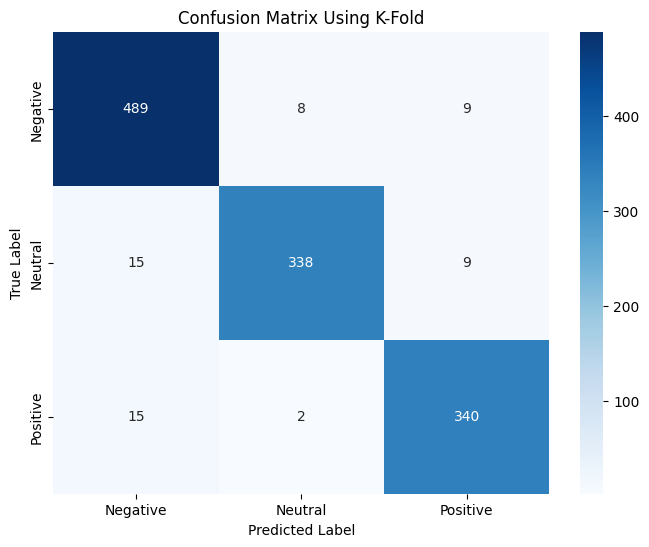

In [ ]:
# Generate confusion matrix
#==========================
confusion_mat = confusion_matrix(y_test, y_pred_bert)

# Create a DataFrame from the confusion matrix
#=============================================
confusion_df = pd.DataFrame(confusion_mat, index=target_names, columns=target_names)

# Plot the confusion matrix
#==========================
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Using K-Fold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ================================

# ================================

#RandomOverSampler(ROS) - [UN=USED]

In [ ]:
# ros = RandomOverSampler()
# train_x, train_y = ros.fit_resample(np.array(df_train['DATA_COLUMN']).reshape(-1, 1), np.array(df_train['LABEL_COLUMN']).reshape(-1, 1))
# df_train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns=['DATA_COLUMN', 'LABEL_COLUMN'])

In [ ]:
# df_train_os['LABEL_COLUMN'].value_counts()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import CountVectorizer
# from imblearn.over_sampling import RandomOverSampler

In [ ]:
# # Step 1: Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(df_train_os['DATA_COLUMN'], df_train_os['LABEL_COLUMN'], test_size=0.2, random_state=42)

In [ ]:
# # Step 2: Apply ROS to the training set
# ros = RandomOverSampler()
# X_train_ros, y_train_ros = ros.fit_resample(X_train.values.reshape(-1, 1), y_train.values)

In [ ]:
# # Step 3: Preprocess and vectorize the text data
# vectorizer = CountVectorizer()
# X_train_vec = vectorizer.fit_transform([str(x[0]) for x in X_train_ros])
# X_test_vec = vectorizer.transform([str(x) for x in X_test])

In [ ]:
# model = LogisticRegression(max_iter=1000)  # Increase the number of iterations
# model.fit(X_train_vec, y_train_ros)


In [ ]:
# # Step 5: Evaluate the model on the original testing data
# y_pred = model.predict(X_test_vec)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='macro')
# recall = recall_score(y_test, y_pred, average='macro')
# f1 = f1_score(y_test, y_pred, average='macro')

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

In [ ]:
# # Step 6: Calculate and display the classification report
# classification_rep = classification_report(y_test, y_pred)
# print("Classification Report:")
# print(classification_rep)

In [ ]:
# # Step 7: Generate and display the confusion matrix
# confusion_mat = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()